In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive
from IPython.display import display, HTML
import coordinate_transforms
import decorr_calculations
import plotting
import importlib
importlib.reload(decorr_calculations)
importlib.reload(coordinate_transforms)
importlib.reload(plotting)

<module 'plotting' from '/Users/ruby/Astro/decorrelation/plotting.py'>

0.24310507124191194
0.7659688349029344
0.9972063764089776


Text(0.5, 1.0, 'Baseline Length 10000 m')

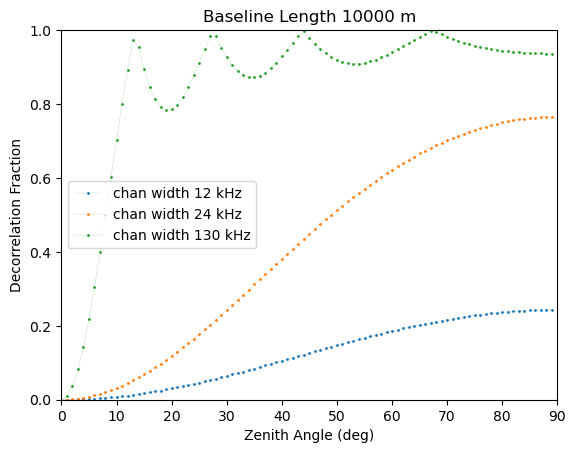

In [3]:
za_list = np.arange(0, 90)
channel_width_khz = [12, 24, 130]
bl_length_m = 10000
for chan_width in channel_width_khz:
    freq_decorr = decorr_calculations.max_fractional_freq_decorr(
        chan_width * 1e3,
        bl_length_m,
        za_list,
    )
    # print(freq_decorr[np.where(za_list==30)])
    print(np.max(freq_decorr))
    plt.plot(za_list, freq_decorr, ".-", markersize=2, linewidth=.1, label=f"chan width {chan_width} kHz")
plt.ylim(0,1)
plt.xlim(0,90)
plt.legend()
plt.xlabel("Zenith Angle (deg)")
plt.ylabel("Decorrelation Fraction")
plt.title(f"Baseline Length {bl_length_m} m")

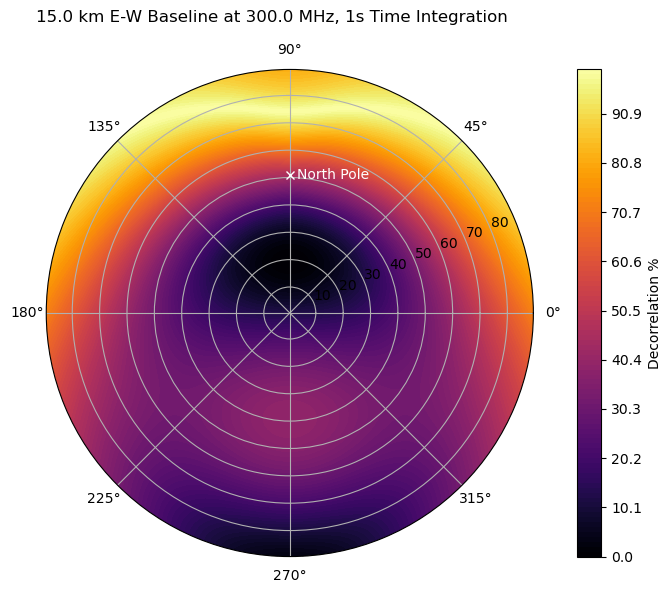

In [4]:
baseline_length_m = 15000
time_integration_s = 1
freq_hz = 300e6
freq_resolution_kHz = 12
plotting.plot_decorrelation(
    time_integration_s,
    np.inf,
    freq_hz,
    freq_resolution_kHz,
    baseline_length_m,
    0,
    title=f"{baseline_length_m/1e3} km E-W Baseline at {freq_hz/1e6} MHz, {time_integration_s}s Time Integration",
    show=False,
    phase_center_ra_offset_hr=0,
    phase_center_dec_deg=58.67923353522443,
    telescope_lat=39.25,
    mark_north_pole=True,
)

In [4]:
freq_resolution_hz = 130e3
time_resolution_s = 1.5
max_bl_length_m = 15e3
freq_hz = 250e6
telescope_lat=39.25

In [5]:
plotting.create_interactive_plot()

interactive(children=(FloatSlider(value=1.5, continuous_update=False, description='Int. Time (s):', layout=Lay…

In [6]:
def get_maximum_decorr_values(time_resolution_s, n_time_steps, freq_resolution_kHz, bl_length):

    za_vals = np.arange(0, 90, 1) + 0.5
    az_vals = np.arange(0, 370, 1) + 0.5
    az_array, za_array = np.meshgrid(az_vals, za_vals)
    ra_vals, dec_vals = coordinate_transforms.az_za_to_ra_dec(
        az_array,  # Units degrees
        za_array,  # Units degrees
        0,  # Units hours (RA of zenith)
        telescope_lat,  # Telescope latitude
    )

    bl_orientation_array = np.arange(0, 180, 5)
    decorr_values = np.zeros((np.shape(ra_vals)[0], np.shape(ra_vals)[1], len(bl_orientation_array)))

    for bl_orient_ind, bl_orientation in enumerate(bl_orientation_array):
        bl_ew_extent_m = bl_length * np.cos(np.radians(bl_orientation))
        bl_ns_extent_m = bl_length * np.sin(np.radians(bl_orientation))
        decorr_values[:, :, bl_orient_ind] = (
            decorr_calculations.fractional_decorr_general(
                time_resolution_s,
                n_time_steps,
                freq_resolution_kHz * 1e3,
                freq_hz,
                bl_ew_extent_m,
                bl_ns_extent_m,
                ra_vals,
                dec_vals,
                phase_center_ra_offset_hr=0,
                phase_center_dec_deg=telescope_lat,
                telescope_lat_deg=telescope_lat,
            )
        )
    return np.max(decorr_values, axis=2)

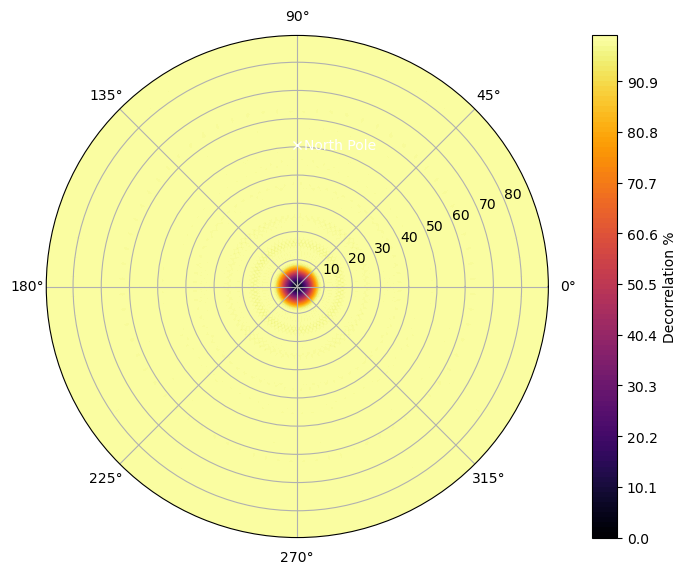

In [7]:
decorr_max = get_maximum_decorr_values(
    0, np.inf, 130, 15000
)
za_vals = np.arange(0, 90, 1) + 0.5
az_vals = np.arange(0, 370, 1) + 0.5
az_array, za_array = np.meshgrid(az_vals, za_vals)
plotting.polar_contour_plot(
    decorr_max * 100,  # Convert to percentage
    np.deg2rad(az_vals),  # Units radians
    za_vals,  # Units degrees
    vmin=0,
    vmax=100,
    ncontours=100,
    title=f"",
    show=True,
)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import imageio
import os


def generate_frames_for_orientation_gif(
    time_resolution_s,
    n_time_steps,
    freq_resolution_kHz,
    bl_length,
    orientation_range=range(0, 181, 10),
    output_dir="frames",
):
    os.makedirs(output_dir, exist_ok=True)

    for bl_orientation in orientation_range:
        plt.figure(figsize=(8, 6))
        plotting.plot_decorrelation_interactive(
            time_resolution_s=time_resolution_s,
            n_time_steps=n_time_steps,
            freq_resolution_kHz=freq_resolution_kHz,
            bl_length=bl_length,
            bl_orientation=bl_orientation,
        )
        frame_path = os.path.join(output_dir, f"frame_{bl_orientation:03d}.png")
        plt.savefig(frame_path)
        plt.close()

generate_frames_for_orientation_gif(
    time_resolution_s=1.5,
    n_time_steps=5,
    freq_resolution_kHz=130,
    bl_length=15000,
    orientation_range=range(0, 181, 5),  # 0° to 180° in 5° steps
)


def create_gif_from_frames(
    frame_dir="frames", gif_name="baseline_orientation.gif", duration=0.2
):
    images = []
    frame_files = sorted([f for f in os.listdir(frame_dir) if f.endswith(".png")])
    for filename in frame_files:
        file_path = os.path.join(frame_dir, filename)
        images.append(imageio.imread(file_path))
    imageio.mimsave(gif_name, images, duration=duration)





create_gif_from_frames()

/Users/ruby/Astro/decorrelation/plotting.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(
/var/folders/x0/sh3xmymj56x6t_05l6hx76zw0000gn/T/ipykernel_84702/3405301628.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 6))
/var/folders/x0/sh3xmymj56x6t_05l6hx76zw0000gn/T/ipykernel_84702/3405301628.py:47: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [9]:
def create_mp4_from_frames(
    frame_dir="frames", video_name="baseline_orientation.mp4", 
):
    frame_files = sorted([f for f in os.listdir(frame_dir) if f.endswith(".png")])
    frame_paths = [os.path.join(frame_dir, f) for f in frame_files]

    writer = imageio.get_writer(video_name)

    for path in frame_paths:
        image = imageio.imread(path)
        writer.append_data(image)

    writer.close()

create_mp4_from_frames()

/var/folders/x0/sh3xmymj56x6t_05l6hx76zw0000gn/T/ipykernel_84702/1610279028.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(path)
